In [48]:
import torch
from ptbxlae.modeling.resnet1dVAE import Resnet1dVAE

In [49]:
torch.no_grad()
m = Resnet1dVAE.load_from_checkpoint('../cache/savedmodels/last-v10.ckpt')
m.eval()

/home/isears/VirtualEnvironments/default/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Resnet1dVAE(
  (encoder): Resnet1dEncoder(
    (conv): Conv1d(12, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (conv2): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (conv2): Conv1d(24, 24, kernel_size=(5,), stride=(1,),

In [50]:
from ptbxlae.dataprocessing.ptbxlDS import PtbxlCleanDS

SAMPLE_IDX = 100

ds = PtbxlCleanDS(root_folder="../data", lowres=False)
sig = ds[SAMPLE_IDX]
sig.shape

torch.Size([12, 5000])

In [51]:
encoded = m.encoder(sig.to('cuda').unsqueeze(0))

encoded.squeeze()

tensor([ 0.0399, -0.0048, -0.0196,  0.0166, -0.0005,  0.0919,  0.0129, -0.0127,
        -0.0297, -0.0157, -0.0092,  0.0875,  0.0476, -0.0049,  0.0140, -0.0070,
        -0.0356,  0.0291, -0.0659, -0.0553,  0.0259,  0.0272,  0.0198,  0.0311,
        -0.0345,  0.0095, -0.0518,  0.0292, -0.0237,  0.0057, -0.0168,  0.0134,
         0.0826,  0.0270, -0.0169, -0.0352, -0.0133, -0.0114, -0.0488, -0.0866],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

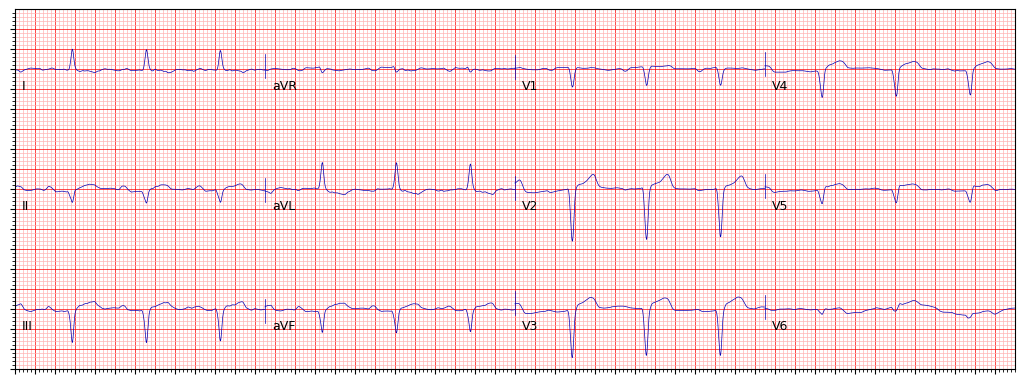

In [52]:
from ptbxlae.dataprocessing import plot_raw_data

# before
plot_raw_data(sig, {'fs': 500})

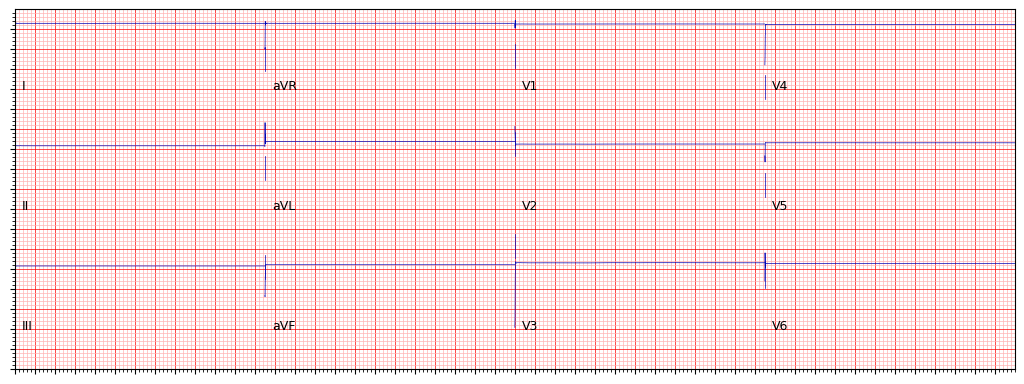

In [53]:
# After
decoded = m.decoder(encoded)
plot_raw_data(decoded[0].detach().to('cpu').numpy() * 100, {'fs': 500})

In [54]:
decoded[0,5,:]

tensor([ 0.0033,  0.0031,  0.0081,  ...,  0.0109,  0.0068, -0.0003],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [55]:
sig[5,:]

tensor([0.0555, 0.0584, 0.0613,  ..., 0.0028, 0.0025, 0.0023])

In [56]:
torch.nn.functional.mse_loss(decoded[0,5,:], sig[5,:].to('cuda'))

tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

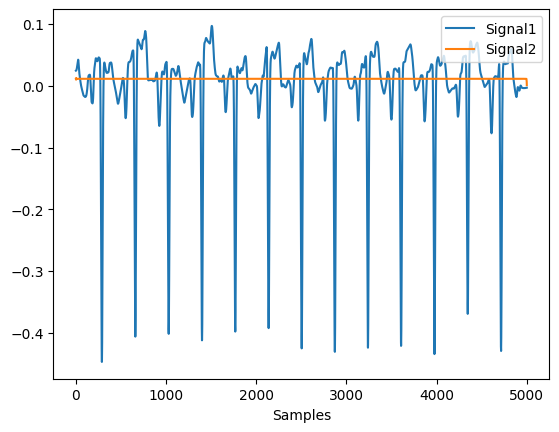

In [57]:
import neurokit2 as nk

#sigproc, info = nk.ecg_process(sig[5], sampling_rate=500)
channel = 6
nk.signal_plot([sig[channel], decoded[0,channel,:].detach().cpu()])